## 📊 Diabetes Prediction - Model Training

#### 🧰 Import Libraries

In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [86]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

#### 📥 Load Dataset

In [87]:
df = pd.read_csv('../data/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


#### 🧹 Preprocessing - Clean Missing & Zero Values

In [88]:
cols_to_clean = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_to_clean] = df[cols_to_clean].replace(0, np.nan)
df.fillna(df.mean(), inplace=True)
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

#### 📊 Exploratory Data Analysis (EDA)

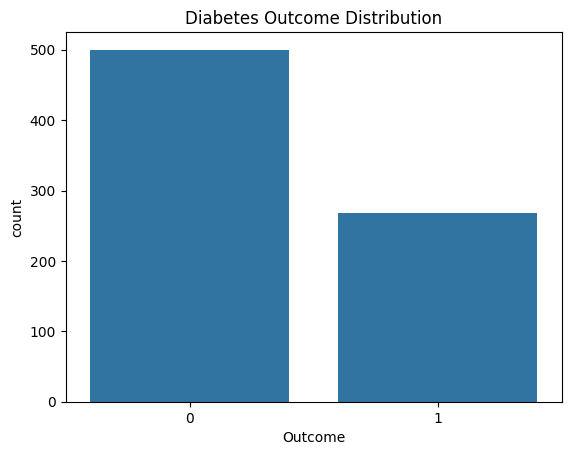

In [89]:
sns.countplot(x='Outcome', data=df)
plt.title('Diabetes Outcome Distribution')
plt.show()

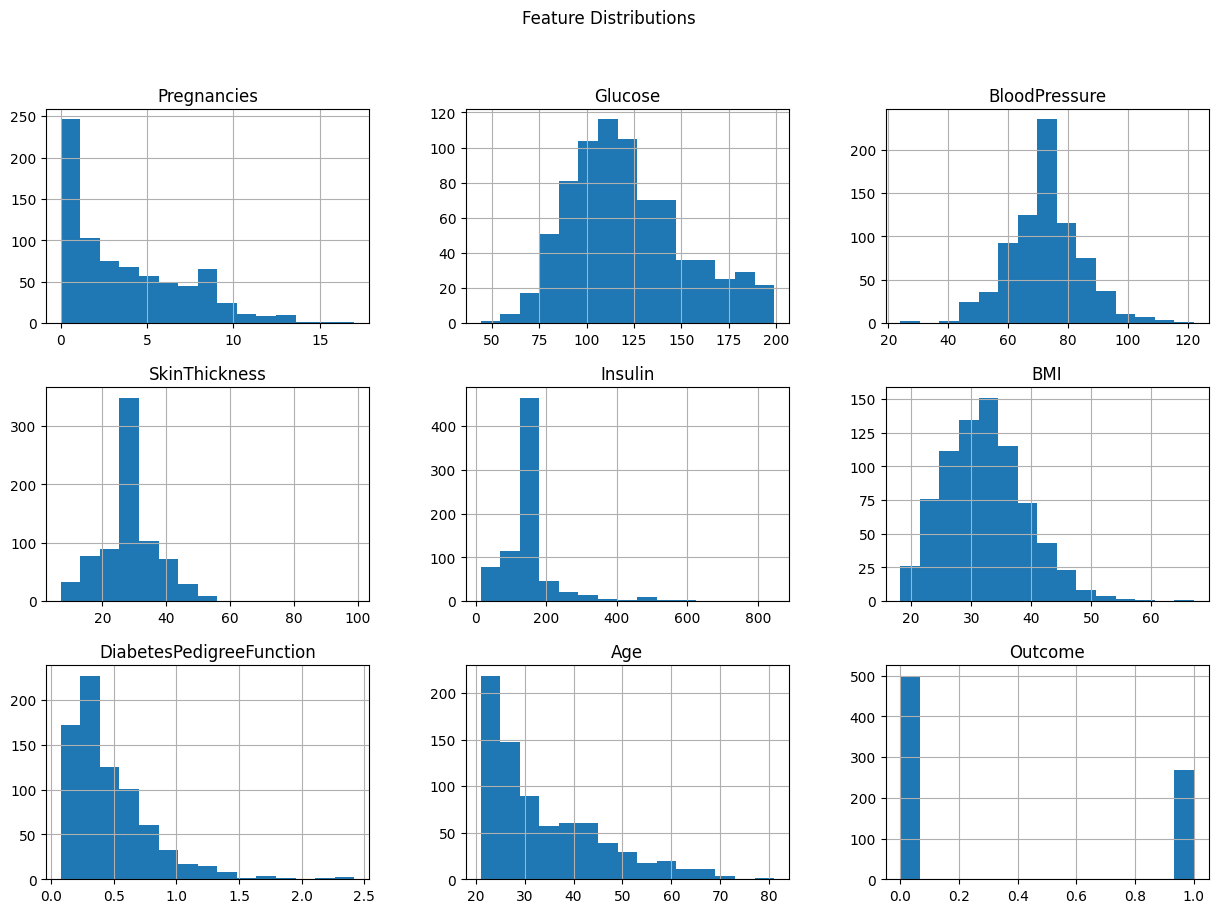

In [90]:
df.hist(bins=15, figsize=(15, 10))
plt.suptitle("Feature Distributions")
plt.show()

#### 📌 Correlation Matrix

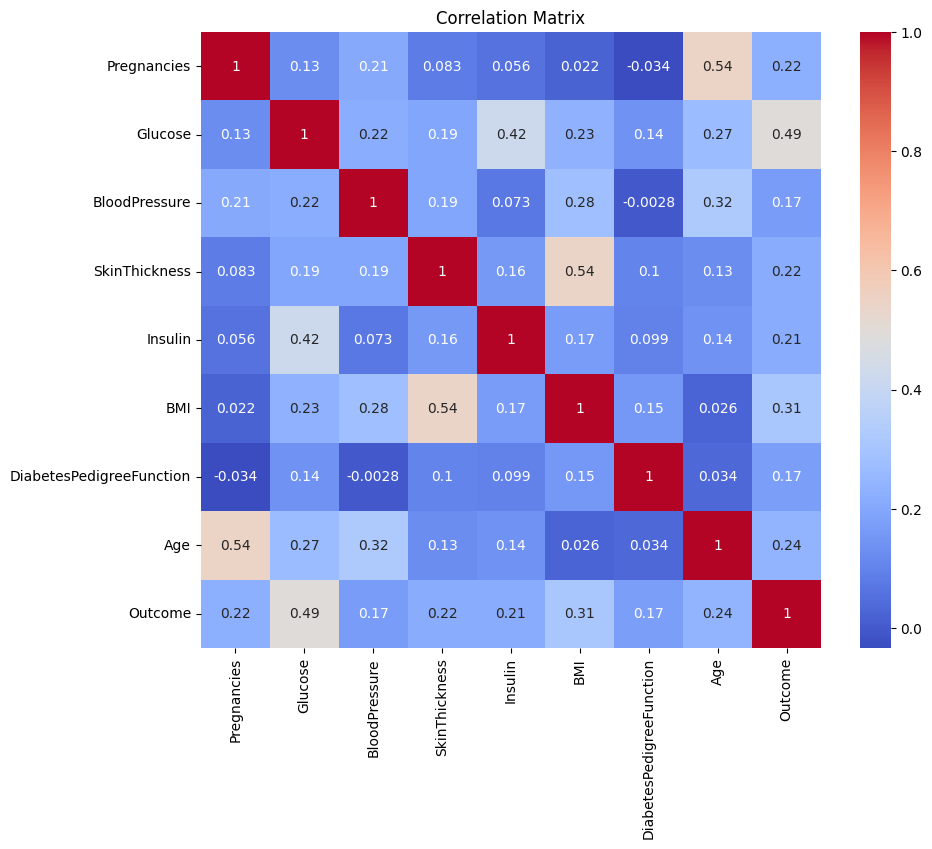

In [91]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#### 🔍 SHAP - Explainable AI

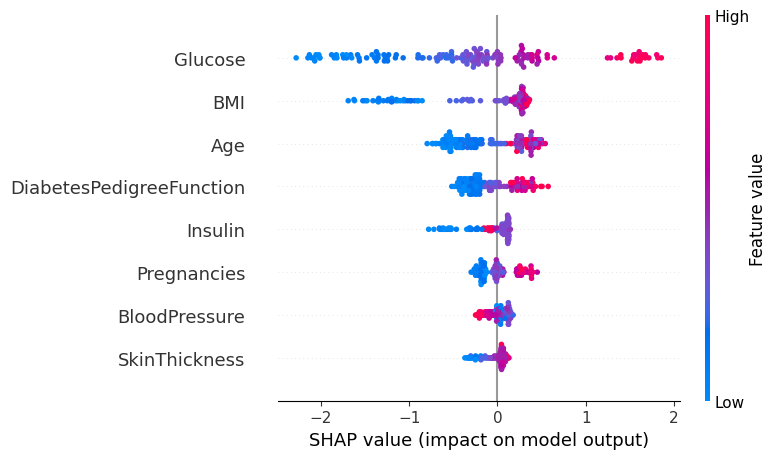

In [92]:
import shap

explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, feature_names=df.drop('Outcome', axis=1).columns)

#### ⚠️ Outlier Detection using Z-Score

In [93]:
from scipy import stats
import numpy as np

features = ["Glucose", "BMI", "Age"]

z_scores = np.abs(stats.zscore(df[features]))
df = df[(z_scores < 3).all(axis=1)]

df.shape


(758, 9)

#### 🔄 Feature Scaling

In [94]:
from sklearn.preprocessing import StandardScaler

features = ["Glucose", "BMI", "Age"]

scaler = StandardScaler()
X = scaler.fit_transform(df[features])
y = df["Outcome"]


#### 🤖 Train the XGBoost Model

In [95]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
neg, pos = y_train.value_counts()
scale_pos_weight = neg / pos


In [ ]:
param_dist = {
    "n_estimators": [400, 600, 800],
    "learning_rate": [0.01, 0.03, 0.05],
    "max_depth": [3, 4],
    "min_child_weight": [3, 5, 7],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
    "gamma": [0, 0.1, 0.2],
    "scale_pos_weight": [
        scale_pos_weight * 0.8,
        scale_pos_weight,
        scale_pos_weight * 1.2
    ]
}


In [ ]:
search = RandomizedSearchCV(
    estimator=XGBClassifier(
        eval_metric="logloss",
        random_state=42
    ),
    param_distributions=param_dist,
    n_iter=30,
    scoring="f1",         
    cv=5,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train, y_train)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


,estimator,"XGBClassifier...ree=None, ...)"
,param_distributions,"{'colsample_bytree': [0.7, 0.8, ...], 'gamma': [0, 0.1, ...], 'learning_rate': [0.01, 0.03, ...], 'max_depth': [3, 4], ...}"
,n_iter,30
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [ ]:
best_model = search.best_estimator_

print("Best Hyperparameters:")
print(search.best_params_)


Best Hyperparameters:
{'subsample': 0.9, 'scale_pos_weight': 2.2140845070422532, 'n_estimators': 400, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.7}


#### ✅ Evaluation Metrics

              precision    recall  f1-score   support

           0       0.88      0.69      0.77       102
           1       0.56      0.80      0.66        50

    accuracy                           0.72       152
   macro avg       0.72      0.74      0.71       152
weighted avg       0.77      0.72      0.73       152



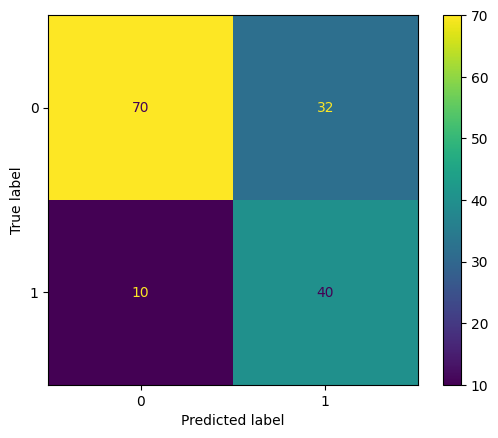

In [100]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


#### 🔁 Cross-Validation

In [101]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')
print("CV Accuracy Scores:", scores)
print("Mean CV Accuracy:", scores.mean())

CV Accuracy Scores: [0.74342105 0.67763158 0.77631579 0.77483444 0.7615894 ]
Mean CV Accuracy: 0.7467584524224468


#### 💾 Save Model and Scaler

In [102]:
import joblib

joblib.dump(best_model, '../models/model.pkl')
joblib.dump(scaler, '../models/scaler.pkl')
print("Model and scaler saved to '../models/'")

Model and scaler saved to '../models/'
